In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import pandas as pd
from hazardGAN import utils
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


def perc_rank(x):
    return x.rank(pct=True)


def deseasonalise_df(df, model='additive', period=12):
    df_deseasonalised = df.copy()
    columns = df.columns
    for col in columns:
        decomposition = seasonal_decompose(df[col], model=model, period=period)
        df_deseasonalised[col] = df[col] - decomposition.seasonal
    return df_deseasonalised

def deseasonalise_df(df, months=[5, 6, 7, 8]):
    df_deseasonalised = df.copy()
    df_deseasonalised = df_deseasonalised.set_index(pd.to_datetime(df['time']))
    df_deseasonalised['month'] = df_deseasonalised.index.month
    df_deseasonalised = df_deseasonalised[df_deseasonalised['month'].apply(lambda x: x in months)]
    df_deseasonalised = df_deseasonalised.set_index('time')
    return df_deseasonalised

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [2]:
basedir = os.path.join("/Users/alison/Documents/DPhil/multivariate")
winddir = os.path.join(basedir, 'wind_data')
wavedir = os.path.join(basedir, "wave_data")
precipdir = os.path.join(basedir, "precip_data")

In [3]:

wind_df = pd.read_csv(os.path.join(winddir,"daily", "total_dailymax.csv"), index_col=[0])
wind_df = deseasonalise_df(wind_df) # TODO: this isn't changing much, compare to stl
wind_df.loc[:, '0':] = wind_df.loc[:, '0':].apply(perc_rank, axis=0)
wind_df['q_total'] = wind_df.loc[:, '0':].mean(axis=1)


In [4]:
wave_df = pd.read_csv(os.path.join(wavedir,"daily", "swh_dailymax.csv"), index_col=[0])
wave_df = deseasonalise_df(wave_df) # TODO: this isn't changing much, compare to stl
wave_df.loc[:, '0':] = wave_df.loc[:, '0':].apply(perc_rank, axis=0)
wave_df['q_total'] = wave_df.loc[:, '0':].mean(axis=1)

In [5]:
precip_df = pd.read_csv(os.path.join(precipdir,"daily", "tp_dailymax.csv"), index_col=[0])
precip_df = deseasonalise_df(precip_df) # TODO: this isn't changing much, compare to stl
precip_df.loc[:, '0':] = precip_df.loc[:, '0':].apply(perc_rank, axis=0)
precip_df['q_total'] = precip_df.loc[:, '0':].mean(axis=1)
# precip_df['time'] = pd.to_datetime(precip_df['time'])
# precip_df = precip_df.set_index('time')

In [6]:
haz_df = wind_df[['cyclone_flag', 'q_total']].copy()
haz_df = pd.concat([haz_df, precip_df['q_total']], axis=1, join='inner')
haz_df = pd.concat([haz_df, wave_df['q_total']], axis=1, join='inner')
haz_df.columns = ['cyclone', 'wind', 'precip', 'wave']
haz_df['q_total'] = haz_df[['wind', 'precip', 'wave']].mean(axis=1)

53 independent maxima extracted from 1230 observations, i.e. 4.31% of the data is used.
Using all of ERA5 from 1940 will have ~1148 samples


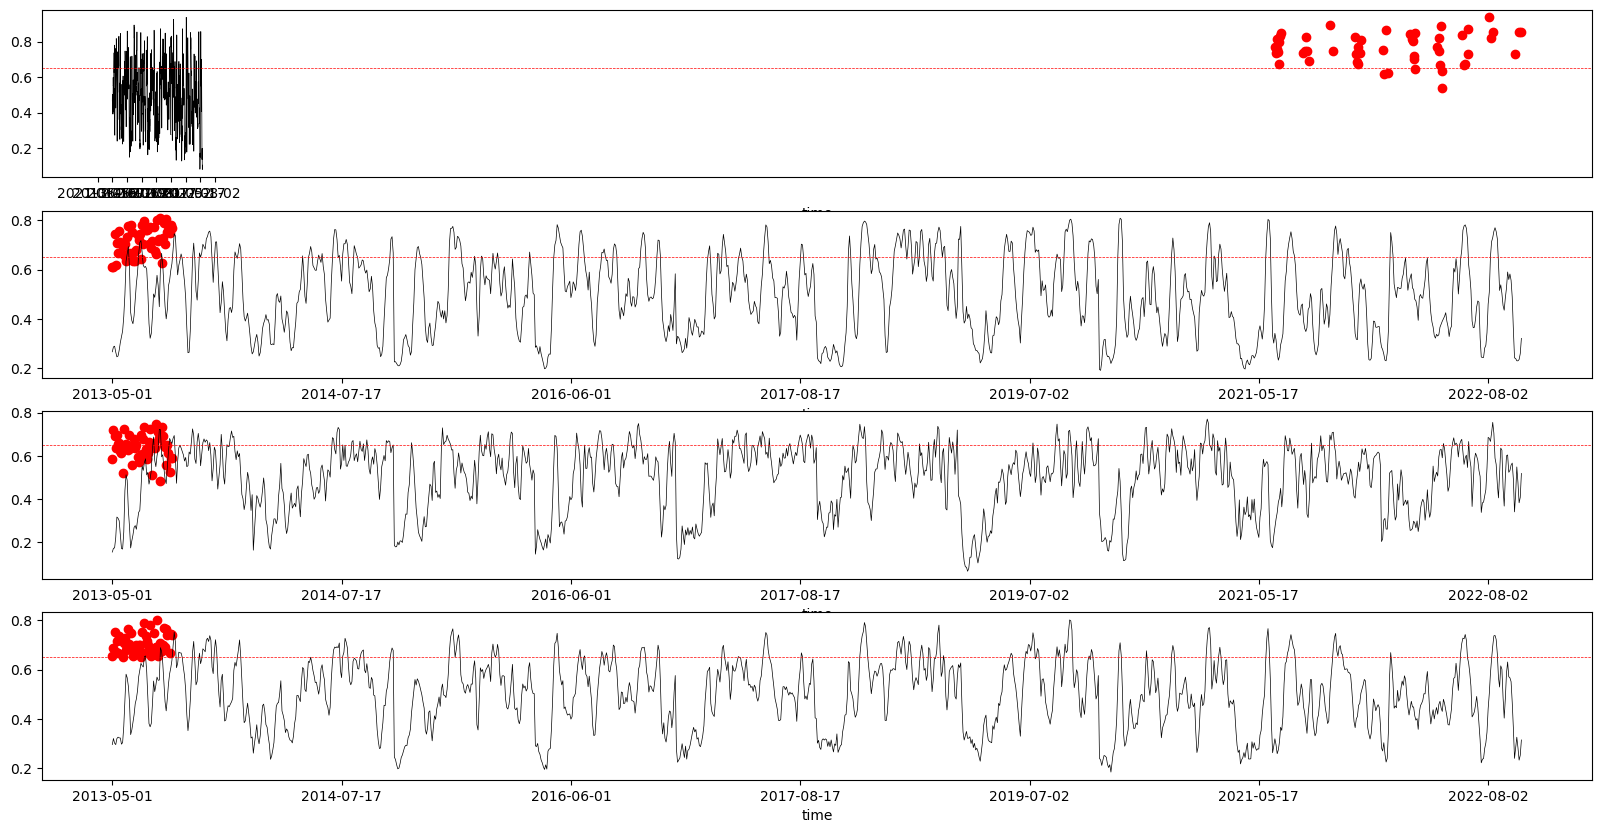

In [26]:
thresh = .65

idx_declust = utils.decluster_array(haz_df['q_total'], thresh, 1)
cluster_maxima = haz_df['q_total'].iloc[idx_declust]

fig, axs = plt.subplots(4, 1, figsize=(20, 10))

ax = axs[0]
wind_df['q_total'].plot(ax=ax, linewidth=.5, color='k')
ax.scatter(pd.to_datetime(cluster_maxima.index), wind_df.iloc[idx_declust, :]['q_total'], color='red')
ax.axhline(thresh, color='red', linewidth=.5, linestyle='dashed')

ax = axs[1]
wave_df['q_total'].plot(ax=ax, linewidth=.5, color='k')
ax.scatter(wave_df.iloc[idx_declust, :]['q_total'].index, wave_df.iloc[idx_declust, :]['q_total'], color='red')
ax.axhline(thresh, color='red', linewidth=.5, linestyle='dashed')

ax = axs[2]
precip_df['q_total'].plot(ax=ax, linewidth=.5, color='k')
ax.scatter(precip_df.iloc[idx_declust, :]['q_total'].index, precip_df.iloc[idx_declust, :]['q_total'], color='red')
ax.axhline(thresh, color='red', linewidth=.5, linestyle='dashed')

ax = axs[3]
haz_df['q_total'].plot(ax=ax, linewidth=.5, color='k')
ax.scatter(cluster_maxima.index, cluster_maxima, color='red')
ax.axhline(thresh, color='red', linewidth=.5, linestyle='dashed')

perc = len(cluster_maxima)/len(haz_df)
print("{} independent maxima extracted from {} observations, i.e. {:.2%} of the data is used.".format(len(cluster_maxima), len(haz_df), perc))
print("Using all of ERA5 from 1940 will have ~{:.0f} samples".format(73 * 365 * perc))

,0,1,2,3,4,5,6,7,8,9,...,3712,3713,3714,3715,3716,3717,3718,3719,3720,q_total
time,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.396445,0.442257,0.470714,0.454637,0.454281,0.466511,0.510269,0.522661,0.554049,0.586624,...,0.323109,0.242302,0.193572,0.274086,0.161713,0.144380,0.348104,0.411965,0.319432,0.423730
2013-01-02,0.267880,0.271642,0.257080,0.242418,0.201872,0.234710,0.273233,0.301150,0.326876,0.350111,...,0.272338,0.293070,0.252504,0.327646,0.409552,0.455651,0.516081,0.445597,0.165831,0.360850
2013-01-03,0.231613,0.318041,0.368909,0.403481,0.411798,0.421327,0.449942,0.468202,0.474398,0.476809,...,0.427593,0.445387,0.494603,0.519304,0.523751,0.556523,0.607876,0.855632,0.794721,0.320109
2013-01-04,0.381432,0.404583,0.400863,0.375574,0.375628,0.386384,0.382273,0.380007,0.387352,0.412836,...,0.360629,0.313240,0.143003,0.310241,0.407175,0.383578,0.076341,0.269474,0.431716,0.383536
2013-01-05,0.408527,0.486909,0.516534,0.550437,0.555777,0.598735,0.630031,0.653682,0.674494,0.690714,...,0.240389,0.170997,0.110893,0.373905,0.376009,0.378479,0.364394,0.328569,0.228820,0.447209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,0.172090,0.191654,0.171028,0.192421,0.223499,0.259687,0.280992,0.277236,0.271856,0.268453,...,0.538947,0.824782,0.740999,0.782755,0.723811,0.810206,0.867756,0.823701,0.760119,0.288264
2022-12-28,0.207234,0.211972,0.237143,0.241329,0.257950,0.284967,0.297783,0.298400,0.297204,0.304312,...,0.312977,0.326639,0.451513,0.592268,0.638712,0.670667,0.605498,0.352272,0.722225,0.245929
2022-12-29,0.184638,0.167315,0.182601,0.172593,0.172299,0.207054,0.226957,0.247481,0.263897,0.280561,...,0.248516,0.241865,0.130379,0.317240,0.389015,0.500558,0.510605,0.301840,0.819171,0.211964
